# Detecção de SPAM

Esse projeto utiliza o dataset 'SMS Spam Collection Dataset' do Kaggle, disponível no link: https://www.kaggle.com/datasets/uciml/sms-spam-collection-dataset

In [23]:
# Instalação e Importações das bibliotecas

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.utils import plot_model

# Download de recursos do NLTK
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


# DATASET

In [24]:
"""Carrega o dataset spam.csv, que contém mensagens rotuladas como 'spam' ou 'ham'.
Realiza limpeza inicial e apresenta o dataframe resultante."""

# Carregando o dataset
arquivo = 'spam.csv'
df = pd.read_csv(arquivo, encoding='latin-1')

# Renomeando e removendo colunas desnecessárias
df = df.rename(columns={'v1': 'label', 'v2': 'mensagem'})[['label', 'mensagem']]

# Visualizações iniciais
print(df.head())
print(df.info())
print(df.describe())
print(df)

  label                                           mensagem
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   label     5572 non-null   object
 1   mensagem  5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB
None
       label                mensagem
count   5572                    5572
unique     2                    5169
top      ham  Sorry, I'll call later
freq    4825                      30
     label                                           mensagem
0      ham  Go until jurong point, crazy.. Available only ...
1      ham                      O

# ANÁLISE EXPLORATÓRIA

Dimensões do dataset: (5572, 2)

Distribuição de classes:


,count
label,
ham,4825
spam,747


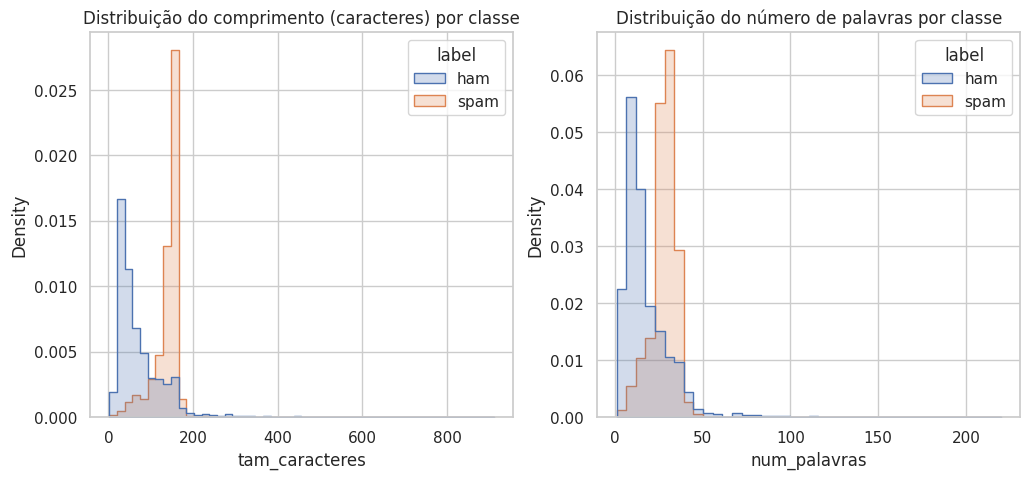

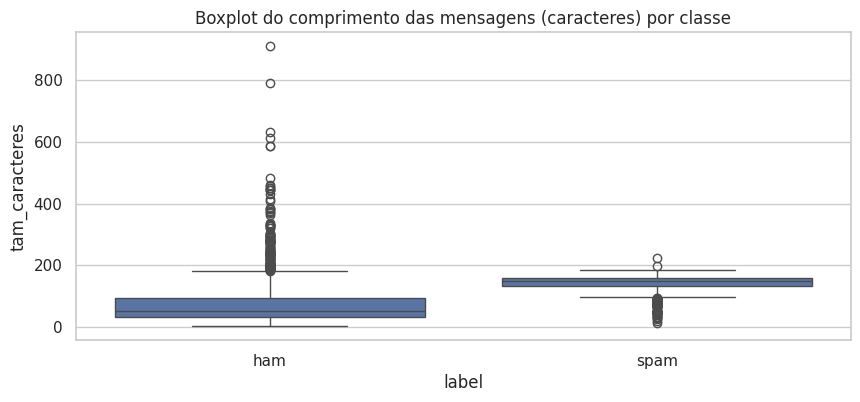

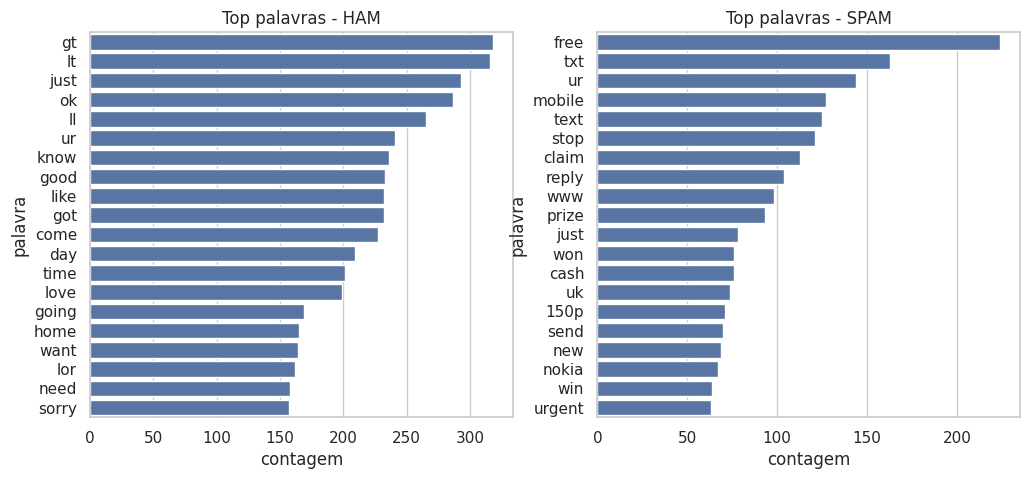

,palavra,contagem
0,gt,318
1,lt,316
2,just,293
3,ok,287
4,ll,265
5,ur,241
6,know,236
7,good,233
8,like,232
9,got,232


,palavra,contagem
0,free,224
1,txt,163
2,ur,144
3,mobile,127
4,text,125
5,stop,121
6,claim,113
7,reply,104
8,www,98
9,prize,93


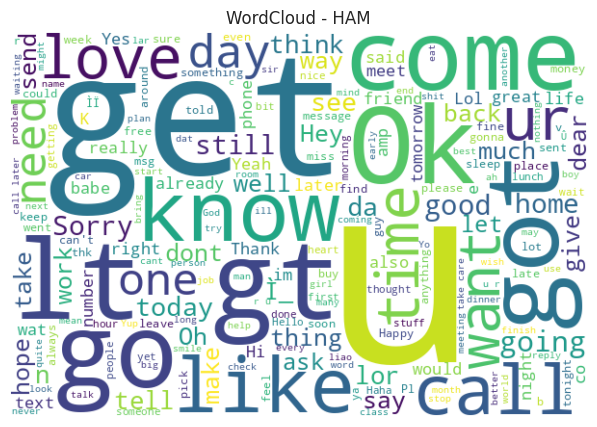

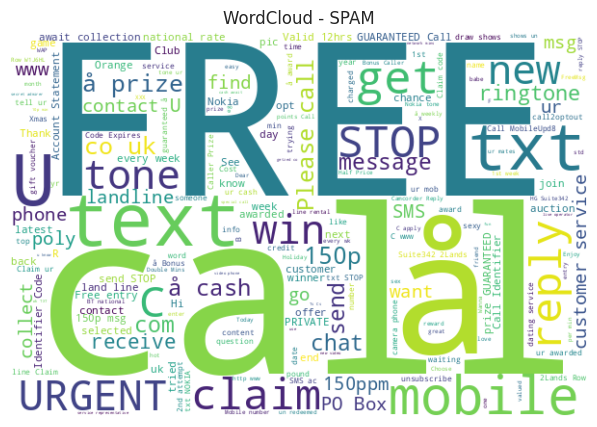

,tem_link,num_count,excl_count
label,,,
ham,0.000622,0.254922,0.173886
spam,0.143240,4.449799,0.725569


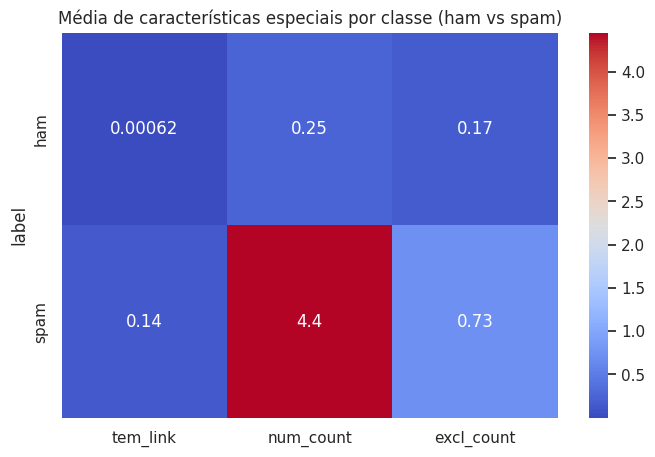

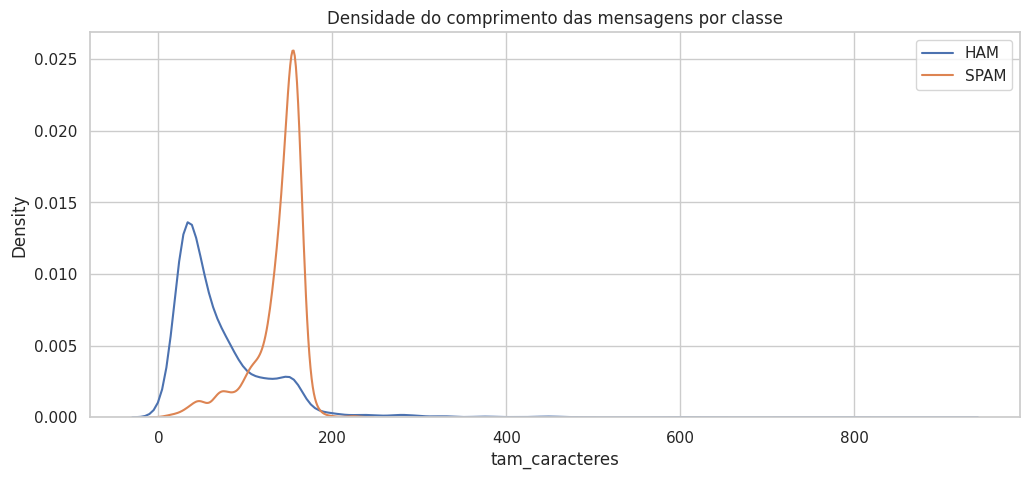

In [25]:
# ANÁLISE EXPLORATÓRIA


# Configurações de plot
sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (12,5)

# 1. Estatísticas básicas
print("Dimensões do dataset:", df.shape)
print("\nDistribuição de classes:")
display(df['label'].value_counts())

# 2. Comprimento das mensagens
# Adiciona colunas com número de caracteres e número de palavras
df['tam_caracteres'] = df['mensagem'].apply(len)
df['num_palavras'] = df['mensagem'].apply(lambda x: len(nltk.word_tokenize(x)))

# Histograma do comprimento das mensagens
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.histplot(data=df, x='tam_caracteres', hue='label', element='step', stat='density', common_norm=False, bins=50)
plt.title('Distribuição do comprimento (caracteres) por classe')

plt.subplot(1,2,2)
sns.histplot(data=df, x='num_palavras', hue='label', element='step', stat='density', common_norm=False, bins=40)
plt.title('Distribuição do número de palavras por classe')
plt.show()

# 3. Boxplot para detectar outliers
plt.figure(figsize=(10,4))
sns.boxplot(x='label', y='tam_caracteres', data=df)
plt.title('Boxplot do comprimento das mensagens (caracteres) por classe')
plt.show()

# 4. Top palavras mais frequentes por classe
from sklearn.feature_extraction.text import CountVectorizer

def top_palavras(corpus, n=20):
    vectorizer = CountVectorizer(stop_words='english')
    X = vectorizer.fit_transform(corpus)
    sums = X.sum(axis=0)
    palavras = vectorizer.get_feature_names_out()
    contagens = np.array(sums).ravel()
    top_idx = contagens.argsort()[::-1][:n]
    return pd.DataFrame({'palavra': palavras[top_idx], 'contagem': contagens[top_idx]})

top_ham = top_palavras(df[df['label']=='ham']['mensagem'])
top_spam = top_palavras(df[df['label']=='spam']['mensagem'])

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.barplot(y='palavra', x='contagem', data=top_ham)
plt.title('Top palavras - HAM')
plt.subplot(1,2,2)
sns.barplot(y='palavra', x='contagem', data=top_spam)
plt.title('Top palavras - SPAM')
plt.show()

display(top_ham.head(10))
display(top_spam.head(10))

# 5. WordCloud por classe
def gerar_wordcloud(texto, titulo='WordCloud'):
    wc = WordCloud(width=600, height=400, background_color='white', stopwords=set(stopwords.words('english')))
    wc.generate(" ".join(texto))
    plt.figure(figsize=(8,5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(titulo)
    plt.show()

gerar_wordcloud(df[df['label']=='ham']['mensagem'], 'WordCloud - HAM')
gerar_wordcloud(df[df['label']=='spam']['mensagem'], 'WordCloud - SPAM')

# 6. Características especiais
# Presença de links, números, exclamações
df['tem_link'] = df['mensagem'].str.contains(r'http|www', case=False, na=False)
df['num_count'] = df['mensagem'].str.count(r'\d+')
df['excl_count'] = df['mensagem'].str.count('!')

# Médias por classe
caracteristicas = ['tem_link','num_count','excl_count']
media_caract = df.groupby('label')[caracteristicas].mean()
display(media_caract)

plt.figure(figsize=(8,5))
sns.heatmap(media_caract, annot=True, cmap='coolwarm')
plt.title('Média de características especiais por classe (ham vs spam)')
plt.show()

# 7. Densidade de comprimento
plt.figure()
sns.kdeplot(df[df['label']=='ham']['tam_caracteres'], label='HAM')
sns.kdeplot(df[df['label']=='spam']['tam_caracteres'], label='SPAM')
plt.legend()
plt.title('Densidade do comprimento das mensagens por classe')
plt.show()


# PRÉ-PROCESSAMENTO

In [ ]:
## Pré-processamento de Texto

"""
Executa o pipeline de pré-processamento em PLN para preparar as mensagens antes da vetorização.
Etapas realizadas:
1. Converte todo o texto para letras minúsculas → padroniza as palavras ("Hello" = "hello").
2. Remove URLs e links → elimina ruído não informativo.
3. Remove números e pontuações → foca apenas no conteúdo textual.
4. Tokeniza o texto → separa em palavras individuais (tokens).
5. Remove stopwords → elimina palavras muito comuns sem significado relevante (ex: "the", "is", "and").
Retorna um DataFrame com uma nova coluna contendo o texto limpo.
"""


def limpar_texto(texto):
    # Converte todo o texto para minúsculas
    texto = texto.lower()
    
    # Remove URLs (http, https, www)
    texto = re.sub(r'http\S+|www\S+', '', texto)
    
    # Remove números e caracteres não alfabéticos (mantém apenas letras e espaços)
    texto = re.sub(r'[^a-z\s]', '', texto)
    
    # Tokeniza o texto em palavras individuais
    palavras = nltk.word_tokenize(texto)
    
    # Remove stopwords da língua inglesa
    palavras = [p for p in palavras if p not in stopwords.words('english')]
    
    # Reúne novamente os tokens em uma string limpa
    return ' '.join(palavras)

# Aplica a limpeza a todas as mensagens do DataFrame
df['mensagem_limpa'] = df['mensagem'].apply(limpar_texto)

# Exibe as primeiras linhas para ver o resultado do pré-processamento
print(df[['label', 'mensagem_limpa']].head())



  label                                     mensagem_limpa
0   ham  go jurong point crazy available bugis n great ...
1   ham                            ok lar joking wif u oni
2  spam  free entry wkly comp win fa cup final tkts st ...
3   ham                u dun say early hor u c already say
4   ham        nah dont think goes usf lives around though


# MODELO LSTM COM GLOVE

In [27]:
## Preparação dos Dados e Vetorização GloVe


"""Carrega os vetores GloVe pré-treinados e cria uma matriz de embeddings para o vocabulário do dataset."""

# Tokenização
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['mensagem_limpa'])
sequences = tokenizer.texts_to_sequences(df['mensagem_limpa'])

# Padding
maxlen = 100
X = pad_sequences(sequences, maxlen=maxlen)

# Transformação de rótulos
y = np.where(df['label'] == 'spam', 1, 0)

# Divisão treino/teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Carregar GloVe
glove_path = 'glove.6B.100d.txt'
embeddings_index = {}
with open(glove_path, encoding='utf8') as f:
    for linha in f:
        valores = linha.split()
        palavra = valores[0]
        vetor = np.asarray(valores[1:], dtype='float32')
        embeddings_index[palavra] = vetor

# Criar matriz de embedding
embedding_dim = 100
word_index = tokenizer.word_index
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for palavra, i in word_index.items():
    vetor = embeddings_index.get(palavra)
    if vetor is not None:
        embedding_matrix[i] = vetor

Epoch 1/15


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


56/56 ━━━━━━━━━━━━━━━━━━━━ 22s 325ms/step - accuracy: 0.8513 - loss: 0.3756 - val_accuracy: 0.9406 - val_loss: 0.1624
Epoch 2/15
56/56 ━━━━━━━━━━━━━━━━━━━━ 21s 338ms/step - accuracy: 0.9545 - loss: 0.1321 - val_accuracy: 0.9540 - val_loss: 0.1221
Epoch 3/15
56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 341ms/step - accuracy: 0.9576 - loss: 0.1153 - val_accuracy: 0.9574 - val_loss: 0.1106
Epoch 4/15
56/56 ━━━━━━━━━━━━━━━━━━━━ 22s 376ms/step - accuracy: 0.9598 - loss: 0.1069 - val_accuracy: 0.9686 - val_loss: 0.1062
Epoch 5/15
56/56 ━━━━━━━━━━━━━━━━━━━━ 19s 331ms/step - accuracy: 0.9684 - loss: 0.0880 - val_accuracy: 0.9652 - val_loss: 0.1017
Epoch 6/15
56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 329ms/step - accuracy: 0.9730 - loss: 0.0773 - val_accuracy: 0.9630 - val_loss: 0.0994
Epoch 7/15
56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 353ms/step - accuracy: 0.9800 - loss: 0.0629 - val_accuracy: 0.9697 - val_loss: 0.0887
Epoch 8/15
56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 340ms/step - accuracy: 0.9788 - loss: 0.0666 - val_accuracy: 0.972

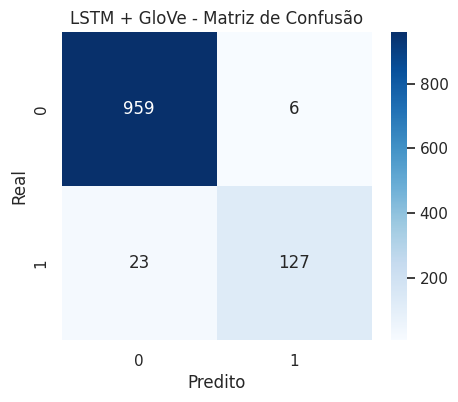

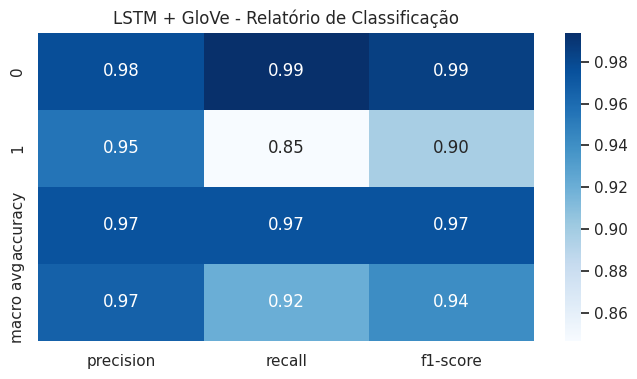

In [32]:
## Modelo LSTM com GloVe


"""Cria, treina e avalia um modelo LSTM usando embeddings GloVe."""

modelo_lstm = Sequential([
    Embedding(len(word_index) + 1, embedding_dim, weights=[embedding_matrix], input_length=maxlen, trainable=False),
    LSTM(128, dropout=0.2, recurrent_dropout=0.2),
    Dense(1, activation='sigmoid')
])

modelo_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
hist = modelo_lstm.fit(X_train, y_train, epochs=15, batch_size=64, validation_split=0.2)

# Avaliação
y_pred = (modelo_lstm.predict(X_test) > 0.5).astype(int).ravel()
acc = accuracy_score(y_test, y_pred)
print(f"Acurácia: {acc:.4f}")

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predito')
plt.ylabel('Real')
plt.title('LSTM + GloVe - Matriz de Confusão')
plt.show()

# Relatório de Classificação
report = classification_report(y_test, y_pred, output_dict=True)
df_report = pd.DataFrame(report).transpose()

plt.figure(figsize=(8,4))
sns.heatmap(df_report.iloc[:-1, :-1], annot=True, cmap='Blues', fmt=".2f")  # exclui média geral
plt.title('LSTM + GloVe - Relatório de Classificação')
plt.show()


# MODELO ALTERNATIVO

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.8446 - loss: 0.5143 - val_accuracy: 0.8621 - val_loss: 0.2034
Epoch 2/15
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.8942 - loss: 0.1544 - val_accuracy: 0.9731 - val_loss: 0.1099
Epoch 3/15
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.9938 - loss: 0.0399 - val_accuracy: 0.9776 - val_loss: 0.0891
Epoch 4/15
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.9982 - loss: 0.0115 - val_accuracy: 0.9753 - val_loss: 0.0874
Epoch 5/15
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.9987 - loss: 0.0054 - val_accuracy: 0.9742 - val_loss: 0.0954
Epoch 6/15
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.9994 - loss: 0.0023 - val_accuracy: 0.9742 - val_loss: 0.1044
Epoch 7/15
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 1.0000 - loss: 0.0013 - val_accuracy: 0.9731 - val_loss: 0.1055
Epoch 8/15
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.9996 - loss: 0.0012 - val_accuracy: 0.9742 - v

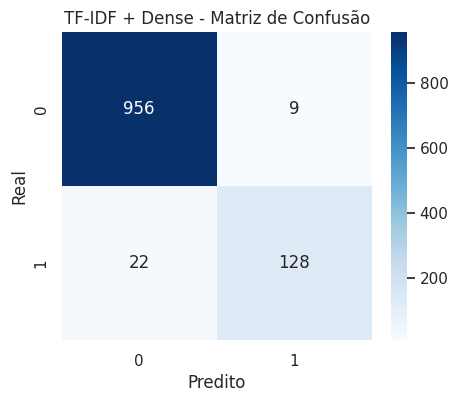

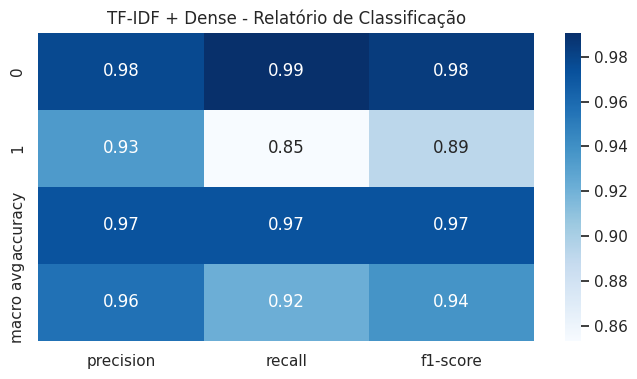

In [34]:

## Modelo Alternativo: TF-IDF + Rede Neural Densa


"""Treina um modelo denso simples com vetorização TF-IDF """

vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = vectorizer.fit_transform(df['mensagem_limpa']).toarray()

X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(
    X_tfidf, y, test_size=0.2, random_state=42
)

modelo_denso = Sequential([
    Dense(256, activation='relu', input_shape=(X_train_tfidf.shape[1],)),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])

modelo_denso.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
hist_dense = modelo_denso.fit(X_train_tfidf, y_train_tfidf, epochs=15, batch_size=64, validation_split=0.2)

y_pred_tfidf = (modelo_denso.predict(X_test_tfidf) > 0.5).astype(int)

# Avaliação
acc_tfidf = accuracy_score(y_test_tfidf, y_pred_tfidf)
print("Acurácia (TF-IDF + Densa):", acc_tfidf)

# Matriz de Confusão
cm = confusion_matrix(y_test_tfidf, y_pred_tfidf)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predito')
plt.ylabel('Real')
plt.title('TF-IDF + Dense - Matriz de Confusão')
plt.show()

# Relatório de Classificação
report = classification_report(y_test_tfidf, y_pred_tfidf, output_dict=True)
df_report = pd.DataFrame(report).transpose()
plt.figure(figsize=(8,4))
sns.heatmap(df_report.iloc[:-1, :-1], annot=True, cmap='Blues', fmt='.2f')
plt.title('TF-IDF + Dense - Relatório de Classificação')
plt.show()




# COMPARAÇÃO FINAL

Acurácia LSTM + GloVe: 0.9740
Acurácia TF-IDF + Densa: 0.9722
O modelo LSTM com GloVe apresentou melhor desempenho geral.
Resultados LSTM + GloVe
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step
Acurácia: 0.9740

Relatório de classificação:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99       965
           1       0.95      0.85      0.90       150

    accuracy                           0.97      1115
   macro avg       0.97      0.92      0.94      1115
weighted avg       0.97      0.97      0.97      1115



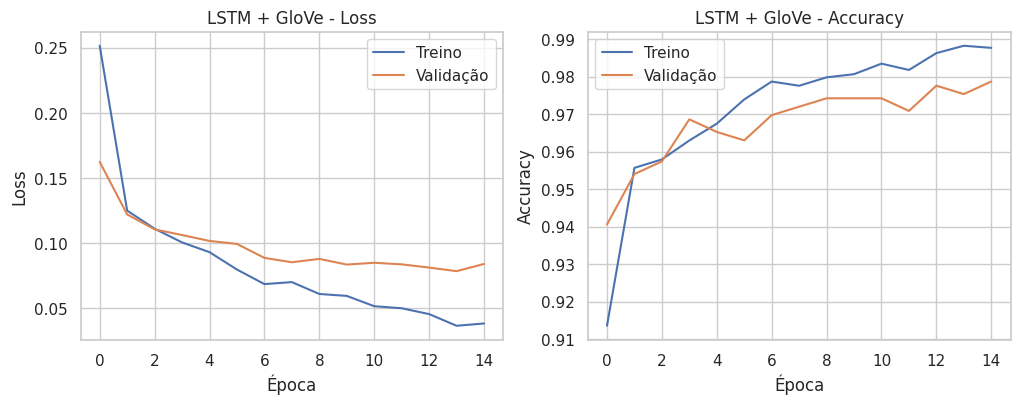

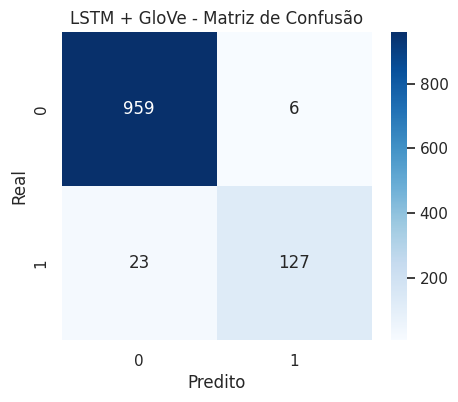

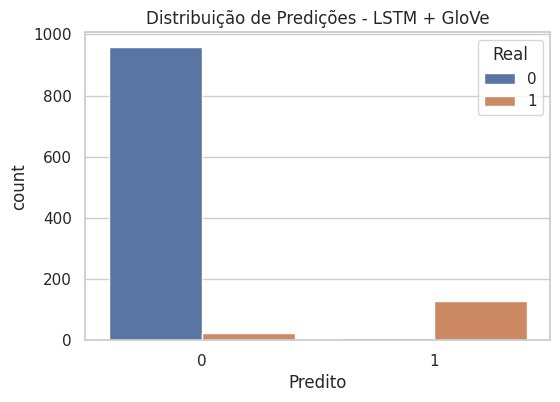

Resultados TF-IDF + Rede Densa
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Acurácia: 0.9722

Relatório de classificação:
               precision    recall  f1-score   support

           0       0.98      0.99      0.98       965
           1       0.93      0.85      0.89       150

    accuracy                           0.97      1115
   macro avg       0.96      0.92      0.94      1115
weighted avg       0.97      0.97      0.97      1115



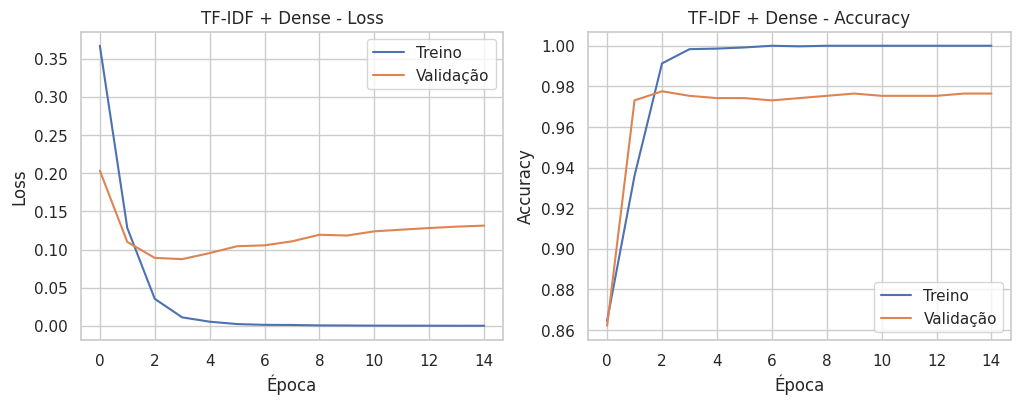

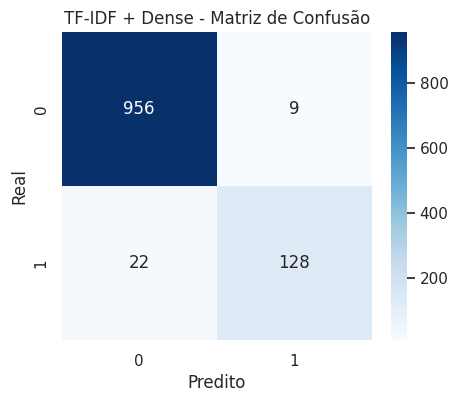

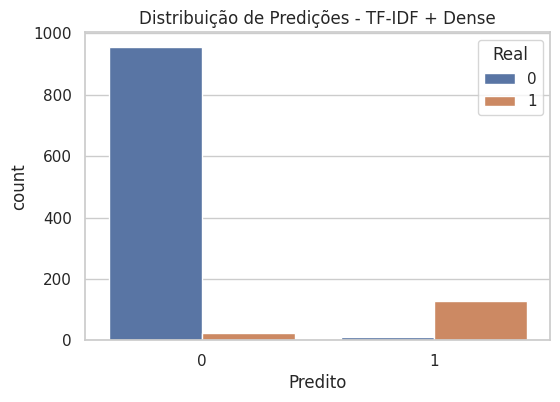

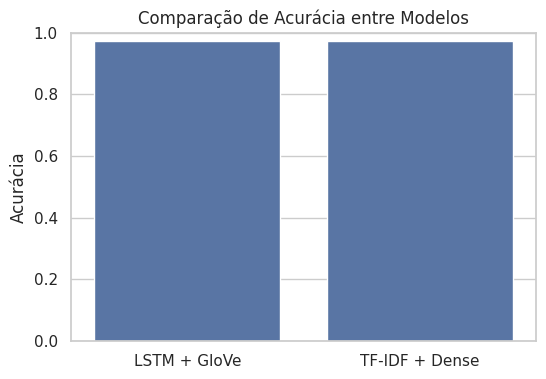

O modelo LSTM com GloVe apresentou melhor desempenho geral.


In [35]:
##  Comparação Final


"""Compara as acurácias dos dois modelos e apresenta conclusão dos resultados obtidos."""

acuracia_lstm = accuracy_score(y_test, y_pred)
acuracia_tfidf = accuracy_score(y_test_tfidf, y_pred_tfidf)

print(f"Acurácia LSTM + GloVe: {acuracia_lstm:.4f}")
print(f"Acurácia TF-IDF + Densa: {acuracia_tfidf:.4f}")

if acuracia_lstm > acuracia_tfidf:
    print("O modelo LSTM com GloVe apresentou melhor desempenho geral.")
else:
    print("O modelo com TF-IDF e rede densa apresentou desempenho semelhante ou superior.")


# Funções auxiliares
def plot_historico(history, titulo='Modelo'):
    plt.figure(figsize=(12,4))
    # Loss
    plt.subplot(1,2,1)
    plt.plot(history.history['loss'], label='Treino')
    plt.plot(history.history['val_loss'], label='Validação')
    plt.title(f'{titulo} - Loss')
    plt.xlabel('Época')
    plt.ylabel('Loss')
    plt.legend()
    # Accuracy
    plt.subplot(1,2,2)
    plt.plot(history.history['accuracy'], label='Treino')
    plt.plot(history.history['val_accuracy'], label='Validação')
    plt.title(f'{titulo} - Accuracy')
    plt.xlabel('Época')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

def plot_conf_matrix(y_true, y_pred, titulo='Matriz de Confusão'):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predito')
    plt.ylabel('Real')
    plt.title(titulo)
    plt.show()

def plot_distribuicao(y_true, y_pred, titulo='Distribuição de Predições'):
    df_plot = pd.DataFrame({'Real': y_true, 'Predito': y_pred})
    plt.figure(figsize=(6,4))
    sns.countplot(x='Predito', hue='Real', data=df_plot)
    plt.title(titulo)
    plt.show()

# LSTM + GloVe
#  Comparação Final

# LSTM + GloVe
print("Resultados LSTM + GloVe")
y_pred_lstm = (modelo_lstm.predict(X_test) > 0.5).astype(int).ravel()  # <--- ravel() para 1D
acuracia_lstm = accuracy_score(y_test, y_pred_lstm)
print(f"Acurácia: {acuracia_lstm:.4f}")
print("\nRelatório de classificação:\n", classification_report(y_test, y_pred_lstm))

plot_historico(hist, 'LSTM + GloVe')
plot_conf_matrix(y_test, y_pred_lstm, 'LSTM + GloVe - Matriz de Confusão')
plot_distribuicao(y_test, y_pred_lstm, 'Distribuição de Predições - LSTM + GloVe')

# TF-IDF + Dense
print("Resultados TF-IDF + Rede Densa")
y_pred_tfidf = (modelo_denso.predict(X_test_tfidf) > 0.5).astype(int).ravel()  # <--- ravel() para 1D
acuracia_tfidf = accuracy_score(y_test_tfidf, y_pred_tfidf)
print(f"Acurácia: {acuracia_tfidf:.4f}")
print("\nRelatório de classificação:\n", classification_report(y_test_tfidf, y_pred_tfidf))

plot_historico(hist_dense, 'TF-IDF + Dense')  # usar hist_dense, não hist
plot_conf_matrix(y_test_tfidf, y_pred_tfidf, 'TF-IDF + Dense - Matriz de Confusão')
plot_distribuicao(y_test_tfidf, y_pred_tfidf, 'Distribuição de Predições - TF-IDF + Dense')

# Gráfico comparativo
plt.figure(figsize=(6,4))
sns.barplot(x=['LSTM + GloVe','TF-IDF + Dense'], y=[acuracia_lstm, acuracia_tfidf])
plt.ylim(0,1)
plt.ylabel('Acurácia')
plt.title('Comparação de Acurácia entre Modelos')
plt.show()

if acuracia_lstm > acuracia_tfidf:
    print("O modelo LSTM com GloVe apresentou melhor desempenho geral.")
else:
    print("O modelo TF-IDF + rede densa apresentou desempenho semelhante ou superior.")
